# Vectorstores and Embeddings

## 🎯 What You'll Learn
By the end of this tutorial, you'll understand:
- **How embeddings work** - converting text into numbers that capture meaning
- **How to build** a smart document search system from scratch
- **Common problems** in RAG and how to spot them

## 🔧 What You'll Build
A complete document search system that can find relevant information from PDF documents based on natural language questions.

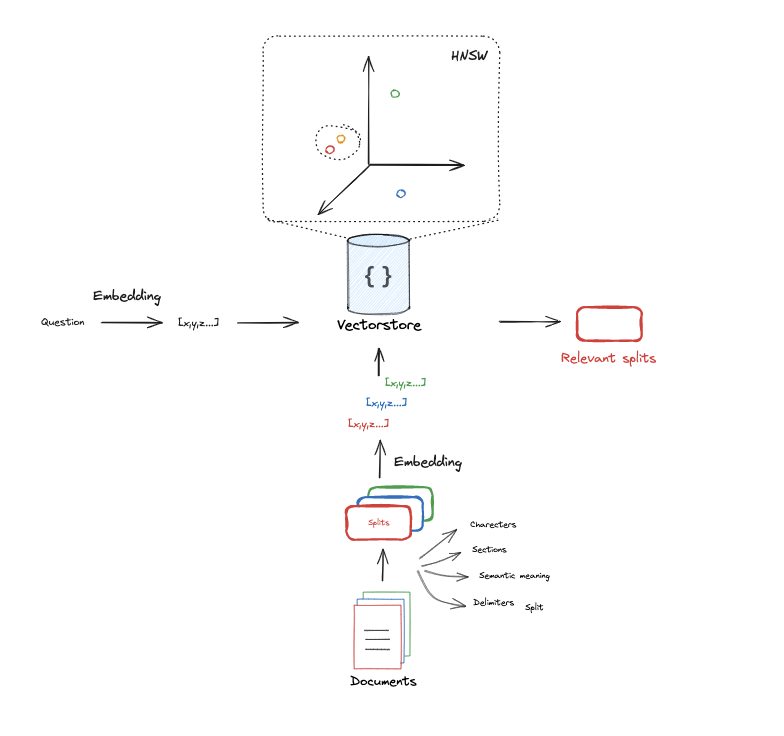

## 📚 The RAG Workflow
```
[Documents] → [Split into chunks] → [Convert to embeddings] → [Store in vector DB]
                                                                        ↓
[Question] → [Convert to embedding] → [Find similar chunks] → [Return relevant content]
```

## Step 0: Understanding What RAG Solves

### 🤔 The Problem
Imagine you have thousands of documents (PDFs, articles, manuals) and you want to:
- Find specific information quickly
- Ask questions in natural language  
- Get relevant answers from the right documents

### ❌ Traditional Search Problems:
- **Keyword search** misses relevant content with different words
- **Reading everything manually** is too slow
- **Can't ask questions** like "What did they say about X in document Y?"

### ✅ RAG Solution:
- **Understands meaning**, not just keywords
- **Searches instantly** through massive document collections
- **Finds relevant information** even if exact words don't match

In [ ]:
print("📚 RAG helps you 'chat' with your documents!")
print("💡 Instead of Ctrl+F, you can ask: 'What are the main benefits of X?'")
print("🎯 Think of it as Google search, but for your personal document collection!")

## Step 1: Installation Requirements

### 🔍 Why Do We Need These Packages?
- **langchain**: The main framework for building RAG systems
- **pypdf**: To read PDF files (like research papers, manuals, etc.)
- **openai**: To convert text into numerical embeddings
- **chromadb**: To store and search through our document vectors
- **numpy**: For mathematical operations on embeddings

In [ ]:
# Install required packages
!pip install langchain
!pip install pypdf
!pip install openai
!pip install chromadb
!pip install numpy

print("✅ All packages installed successfully!")
print("🚀 Ready to build your first RAG system!")

## Step 2: Loading PDF Documents

### 📖 Why These Specific PDFs?
We're using Andrew Ng's famous CS229 Machine Learning course transcripts because:
- **Rich, technical content** - Perfect for testing search capabilities
- **Multiple documents** - Shows how RAG works across document collections
- **Real-world messy data** - Automated transcriptions have imperfect formatting
- **Educational value** - You'll learn about ML while building RAG!

### Download PDF Documents
[MachineLearning-Lecture01](https://see.stanford.edu/materials/aimlcs229/transcripts/machinelearning-lecture01.pdf), 
[MachineLearning-Lecture02](https://see.stanford.edu/materials/aimlcs229/transcripts/MachineLearning-Lecture02.pdf), 
[MachineLearning-Lecture03](https://see.stanford.edu/materials/aimlcs229/transcripts/MachineLearning-Lecture03.pdf)
   

In [ ]:
# Import the PDF loader from LangChain
from langchain.document_loaders import PyPDFLoader
import os

# 🔧 CONFIGURATION: Update this path to where your PDFs are stored
source_path = r"<your-source-path>"  # Change this to your actual folder path

print(f"📂 Looking for PDF files in: {source_path}")
print("💡 Make sure your PDFs are in this folder before continuing!")

In [ ]:
# Create a list of PDF files to load
# 🎯 LEARNING POINT: We're adding the same PDF twice on purpose!
# This simulates real-world scenarios where you might have duplicate content
loaders = [
    # First lecture PDF (added twice to simulate real-world messy data)
    PyPDFLoader(os.path.join(source_path, "MachineLearning-Lecture01.pdf")),
    PyPDFLoader(os.path.join(source_path, "MachineLearning-Lecture01.pdf")),  # 🚨 Intentional duplicate!
    # Additional lecture PDFs
    PyPDFLoader(os.path.join(source_path, "MachineLearning-Lecture02.pdf")),
    PyPDFLoader(os.path.join(source_path, "MachineLearning-Lecture03.pdf"))
]

print("📋 Configured to load 4 PDF files (including 1 duplicate for testing)")

In [ ]:
# Create an empty list to store all our document pages
docs = []

# Load each PDF and add its pages to our docs list
for i, loader in enumerate(loaders):
    print(f"📄 Loading PDF {i+1}/4...")
    # Each PDF might have multiple pages, so we extend (not append) the list
    docs.extend(loader.load())

print(f"📚 Successfully loaded {len(docs)} document pages!")
print(f"📝 Example: First page has {len(docs[0].page_content)} characters")
print(f"📄 First document preview: {docs[0].page_content[:200]}...")

### 🔍 What Just Happened?
1. We told Python where to find our PDF files
2. We loaded each PDF page as a separate document
3. Now we have a list where each item is one page of text
4. Each document has `page_content` (the text) and `metadata` (info about the source)

## Step 3: Understanding Why We Need to Split Documents

### 🤔 Why Split Documents Into Chunks?

#### ❌ Problems with Whole Documents:
- A single PDF page might be **5000+ characters long**
- Contains **multiple topics** mixed together
- Hard to find the **exact relevant part**
- AI models work better with **focused, smaller pieces**

#### ✅ Benefits of Chunking:
- Each chunk focuses on **one topic/concept**
- **Easier to find** precise information
- **Better matching** between questions and content
- **More accurate** retrieval results

#### 📏 Chunk Size Matters:
- **Too small** (100 chars): Loses context, incomplete sentences
- **Too large** (5000 chars): Too much irrelevant info mixed in
- **Just right** (1500 chars): Usually 2-3 paragraphs of focused content

In [ ]:
# Import the text splitter
from langchain.text_splitter import RecursiveCharacterTextSplitter

# 🔧 Create a text splitter with carefully chosen settings
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,      # Each chunk will be about 1500 characters long
    chunk_overlap=150     # Overlap between chunks to maintain context
)

print("🔧 Text splitter configured successfully!")
print(f"📏 Chunk size: 1500 characters (~2-3 paragraphs)")
print(f"🔗 Overlap: 150 characters (keeps context between chunks)")
print()
print("💡 WHY overlap? If a sentence is split between chunks,")
print("   the overlap ensures we don't lose important context!")

### 🎯 Visual Example of Chunking:
```
Original text: "Machine learning is amazing. It can solve many problems. Neural networks are powerful..."

Chunk 1: "Machine learning is amazing. It can solve many problems. Neural..."
Chunk 2: "...problems. Neural networks are powerful. They can learn patterns..."
         ↑ Notice the overlap - keeps context!
```

In [ ]:
# Split all our documents into smaller chunks
splits = text_splitter.split_documents(docs)

print(f"✂️ Split {len(docs)} documents into {len(splits)} smaller chunks")
print(f"📊 That's about {len(splits)/len(docs):.1f} chunks per document page")
print(f"📝 Sample chunk preview: {splits[0].page_content[:300]}...")
print(f"📏 Sample chunk length: {len(splits[0].page_content)} characters")

## Step 4: Understanding Embeddings - The Magic Behind RAG

### 🤔 What Are Embeddings?
**Embeddings** are like converting words into numbers that computers can understand and compare. **Similar meanings get similar numbers.**

### 🎯 Think of It Like This:
- **"I like dogs"** and **"I like canines"** should have similar numbers (high similarity)
- **"I like dogs"** and **"The weather is ugly"** should have very different numbers (low similarity)

### 🔢 How It Works:
1. **Text input**: "I love machine learning"
2. **AI model processes it**: Understands context, meaning, relationships
3. **Output**: A list of 1536 numbers (like `[0.23, -0.15, 0.87, ...]`)
4. **Similar text** gets similar number patterns!

In [ ]:
# Import OpenAI's embedding model
from langchain_openai import OpenAIEmbeddings

# Create an embedding object
# Note: You'll need an OpenAI API key for this to work
embedding = OpenAIEmbeddings()

print("🤖 OpenAI embedding model loaded!")
print("💡 This will convert text into numerical vectors for similarity search")
print("🔑 Make sure you have your OpenAI API key set up in your environment")

### 🧪 Let's Test Embeddings with Real Examples
We'll compare three sentences to see how embeddings capture similarity:

In [ ]:
# Let's test embeddings with three different sentences
sentence1 = "i like dogs"
sentence2 = "i like canines"      # Similar meaning to sentence1
sentence3 = "the weather is ugly outside"  # Completely different meaning

print("📝 Test sentences:")
print(f"1: '{sentence1}'")
print(f"2: '{sentence2}' (similar to #1)")
print(f"3: '{sentence3}' (different from #1 and #2)")
print()
print("🔮 Let's see if AI can understand these relationships...")

In [ ]:
# Convert each sentence into numerical embeddings
print("🔄 Converting sentences to embeddings...")

embedding1 = embedding.embed_query(sentence1)
embedding2 = embedding.embed_query(sentence2)
embedding3 = embedding.embed_query(sentence3)

print(f"🔢 Embedding 1 length: {len(embedding1)} numbers")
print(f"🔢 Embedding 2 length: {len(embedding2)} numbers")
print(f"🔢 Embedding 3 length: {len(embedding3)} numbers")
print(f"📊 First 5 numbers of embedding 1: {embedding1[:5]}")
print()
print("✨ Each sentence is now represented by 1536 decimal numbers!")
print("🎯 Similar meanings should have similar number patterns")

### 🧮 Measuring Similarity Between Embeddings
Now we'll calculate how similar these embeddings are using mathematical operations:

In [ ]:
# Import numpy to calculate similarity between embeddings
import numpy as np

print("📊 NumPy imported for similarity calculations")
print("🔍 We'll use 'dot product' to measure how similar embeddings are")
print("📈 Higher numbers = more similar meanings")

In [ ]:
# Calculate similarity between "dogs" and "canines" (should be high)
similarity_1_2 = np.dot(embedding1, embedding2)
print(f"🐕 Similarity between 'dogs' and 'canines': {similarity_1_2:.4f}")
print("📈 This should be a HIGH number because they mean similar things!")

In [ ]:
# Calculate similarity between "dogs" and "weather" (should be low)
similarity_1_3 = np.dot(embedding1, embedding3)
print(f"🐕🌤️ Similarity between 'dogs' and 'weather': {similarity_1_3:.4f}")
print("📉 This should be a LOWER number because they're unrelated topics!")

In [ ]:
# Calculate similarity between "canines" and "weather" (should also be low)
similarity_2_3 = np.dot(embedding2, embedding3)
print(f"🐺🌤️ Similarity between 'canines' and 'weather': {similarity_2_3:.4f}")

print("\n🎯 Summary of similarities:")
print(f"Dogs ↔ Canines: {similarity_1_2:.4f} (HIGH - similar meanings)")
print(f"Dogs ↔ Weather: {similarity_1_3:.4f} (LOW - different meanings)")
print(f"Canines ↔ Weather: {similarity_2_3:.4f} (LOW - different meanings)")
print()
print("🎉 The AI correctly understands that dogs = canines!")
print("✨ This is the magic that makes RAG work so well!")

### 💡 Why This Matters for RAG
Now you understand the core of RAG! When you ask:
- **"Tell me about canines"** → RAG will find documents about **"dogs"**
- **"Machine learning algorithms"** → RAG will find content about **"ML models"** or **"AI techniques"**
- **"Email for help"** → RAG will find text mentioning **"contact", "support", "assistance"**

This is **way smarter** than keyword search!

## Step 5: Creating a Vector Database - The Search Engine

### 🤔 What's a Vector Database?
A **vector database** is like a super-smart filing cabinet that:
- **Stores** all our document chunks as numerical embeddings
- **Quickly finds** the most similar chunks to any question
- **Ranks results** by how relevant they are

### 🎯 Why We Need It:
- **Speed**: Search through thousands of chunks in milliseconds
- **Accuracy**: Find relevant content even with different words
- **Persistence**: Save our work so we don't have to recreate embeddings

In [ ]:
# Import the Chroma vector database
from langchain.vectorstores import Chroma

print("🗄️ Chroma vector store imported successfully!")
print("💡 Chroma is a popular, easy-to-use vector database")
print("🚀 Perfect for learning and prototyping RAG systems")

In [ ]:
# Set up where we want to save our vector database
persist_directory = 'docs/chroma/'

print(f"📁 Vector database will be saved to: {persist_directory}")
print("💾 This means we can reload it later without recreating everything!")

In [ ]:
# Remove any old database files to start fresh
!rm -rf ./docs/chroma

print("🧹 Cleaned up old database files")
print("🔄 Starting with a fresh vector database")

### ⚠️ This Next Step Takes Time!
We're about to convert **all our document chunks** into embeddings. This involves:
- Sending each chunk to OpenAI's API
- Getting back 1536 numbers for each chunk
- Storing everything in our vector database

**Time estimate**: 30 seconds to 2 minutes (depending on document size and internet speed)

In [ ]:
# Create our vector database from all the document chunks
print("🔄 Creating vector database... This might take a moment.")
print(f"📊 Processing {len(splits)} document chunks...")
print("⏳ Please wait while we convert text to embeddings...")

vectordb = Chroma.from_documents(
    documents=splits,              # Our document chunks
    embedding=embedding,           # The embedding model to convert text to vectors
    persist_directory=persist_directory  # Where to save the database
)

print("✅ Vector database created successfully!")
print("🎯 All document chunks have been converted to vectors and stored")
print("🚀 Ready for smart document search!")

In [ ]:
# Check how many documents are in our database
document_count = vectordb._collection.count()
print(f"📊 Vector database contains {document_count} document chunks")
print(f"💾 Database size: Approximately {document_count * 1536 * 4 / 1024 / 1024:.1f} MB")
print("🎉 Your RAG system is now ready to answer questions!")

## Step 6: Similarity Search - The Heart of RAG

### 🎯 The Magic Moment
Now comes the exciting part! We can ask questions in **natural language** and find the most relevant document chunks automatically.

### 🔍 How It Works:
1. **Your question** gets converted to an embedding (1536 numbers)
2. **Vector database** compares your question embedding to all stored chunks
3. **Most similar chunks** get returned, ranked by relevance
4. **You get answers** from the most relevant parts of your documents!

In [ ]:
# Let's ask a question about the documents
question = "is there an email i can ask for help"

print(f"❓ Question: '{question}'")
print("🔍 Searching through all document chunks...")

# Search for the 3 most similar document chunks
docs = vectordb.similarity_search(question, k=3)

print(f"✅ Found {len(docs)} relevant document chunks")
print("📋 These chunks are ranked by how similar they are to your question")
print("🎯 Let's see what RAG found!")

In [ ]:
# Look at the most relevant document chunk
print("🏆 Most relevant document chunk:")
print("=" * 50)
print(docs[0].page_content)
print("=" * 50)
print(f"📄 Source: {docs[0].metadata}")
print()
print("🎉 RAG found the most relevant information automatically!")
print("💡 Notice how it understood 'email for help' might be related to contact info")

### 🧪 Let's Try More Examples
Let's test RAG with different types of questions to see how versatile it is:

In [ ]:
# Test different types of questions
test_questions = [
    "what is machine learning?",
    "tell me about supervised learning",
    "what did they say about matlab?",
    "how do you define a hypothesis?"
]

print("🧪 Testing RAG with different question types:")
print("=" * 60)

for i, q in enumerate(test_questions, 1):
    print(f"\n📝 Test {i}: '{q}'")
    results = vectordb.similarity_search(q, k=1)
    print(f"📄 Found in: {results[0].metadata.get('source', 'Unknown')}")
    print(f"📝 Preview: {results[0].page_content[:150]}...")

print("\n🎯 Notice how RAG finds relevant content for each question type!")

## Step 7: Saving Our Work

### 💾 Why Save the Database?
Creating embeddings takes time and costs money (API calls). By saving our vector database:
- **Reuse instantly**: Load in future sessions without recreating
- **Save money**: No need to re-process the same documents
- **Share with others**: Send the database file to colleagues

In [ ]:
# Save the vector database to disk
vectordb.persist()

print("💾 Vector database saved successfully!")
print("🔄 You can now reload this database in future sessions")
print(f"📁 Database location: {persist_directory}")
print("⚡ Next time, just load instead of recreating!")

### 🔄 How to Load the Database Later
```python
# In future sessions, load like this:
vectordb = Chroma(
    persist_directory=persist_directory,
    embedding_function=embedding
)
# Now you can search immediately!
```

## Step 8: Understanding RAG Limitations

### 🎯 RAG is Powerful, But Not Perfect!
Let's explore some common problems you might encounter in real-world applications. Understanding these helps you build better systems!

### Problem 1: Duplicate Content

#### 🚨 The Issue
Remember we added the same PDF twice? Let's see what happens when we search for something specific.

#### 💭 Why This Matters
In real applications, you might have:
- Same document in different folders
- Multiple versions of similar content
- Copy-pasted information across documents

In [ ]:
# Ask about a specific topic
question = "what did they say about matlab?"

print(f"❓ Question: '{question}'")
print("🔍 Let's search for 5 results to see if we get duplicates...")

# Search for 5 most similar documents
docs = vectordb.similarity_search(question, k=5)

print(f"📊 Retrieved {len(docs)} document chunks")
print("⚠️ Notice: We might get duplicate content because we loaded the same PDF twice!")

In [ ]:
# Let's examine the first two results
print("🔍 Comparing first two results:")
print("=" * 50)

print("📄 First result:")
print(f"Source: {docs[0].metadata}")
print(f"Content preview: {docs[0].page_content[:200]}...")
print()

print("📄 Second result:")
print(f"Source: {docs[1].metadata}")
print(f"Content preview: {docs[1].page_content[:200]}...")
print()

# Check if they're identical
if docs[0].page_content == docs[1].page_content:
    print("🚨 PROBLEM DETECTED: The first two results are identical!")
    print("💡 This happened because we have duplicate documents in our database")
    print("🔧 Solution: Implement deduplication before creating embeddings")
else:
    print("✅ The first two results are different")
    print("🎯 No duplicates detected in top results")

### Problem 2: Lack of Source Awareness

#### 🚨 The Issue
RAG focuses on **content similarity**, not **source constraints**. Sometimes it retrieves relevant information from the wrong source.

#### 💭 Real-World Example
User asks: *"What did the CEO say about profits in the Q3 report?"*
RAG might return: Content about profits from Q1 or Q2 reports (wrong source, but relevant content)

In [ ]:
# Ask a specific question about the third lecture
question = "what did they say about regression in the third lecture?"

print(f"❓ Question: '{question}'")
print("🎯 We're specifically asking about the THIRD lecture")
print("🔍 Let's see if RAG respects this constraint...")

# Search for relevant documents
docs = vectordb.similarity_search(question, k=5)

print(f"📊 Retrieved {len(docs)} document chunks")
print("📋 Let's check which lectures these results come from:")

In [ ]:
# Check the source of each retrieved document
print("📊 Source Analysis:")
print("=" * 50)

for i, doc in enumerate(docs):
    source_file = doc.metadata.get('source', 'Unknown')
    # Extract just the filename
    filename = source_file.split('/')[-1] if '/' in source_file else source_file.split('\\')[-1]
    print(f"📄 Result {i+1}: {filename}")

print("\n🚨 POTENTIAL PROBLEM:")
print("Even though we asked specifically about 'the third lecture',")
print("RAG might return results from other lectures too!")
print("This is because RAG focuses on content similarity, not source constraints.")
print()
print("🔧 SOLUTIONS:")
print("1. Add metadata filtering to search")
print("2. Pre-process queries to extract source constraints")
print("3. Use a two-step approach: filter by source, then by content")

### Problem 3: Context Window Limitations

#### 🚨 The Issue
Each chunk is independent. Sometimes the answer spans multiple chunks or requires broader context.

#### 💭 Example
- **Question**: "What are the three main types mentioned?"
- **Problem**: The list might be split across chunks
- **Result**: Incomplete or confusing answers

In [ ]:
# Test a question that might require broader context
question = "what are the main topics covered in the course?"

print(f"❓ Question: '{question}'")
print("🔍 This question requires information from across multiple chunks...")

docs = vectordb.similarity_search(question, k=3)

print("📊 Results:")
for i, doc in enumerate(docs):
    print(f"\n📄 Chunk {i+1}:")
    print(f"Content: {doc.page_content[:300]}...")

print("\n💡 Each chunk gives partial information.")
print("🔧 A complete answer would need to synthesize information from multiple chunks.")

## 🎯 Key Takeaways

### 🎉 Congratulations!
You've built your first complete RAG system! Here's what we accomplished:

### ✅ What RAG Does Amazingly Well:
- **🧠 Smart Search**: Finds relevant information even when exact keywords don't match
- **🔍 Semantic Understanding**: Understands that "dogs" and "canines" are related
- **⚡ Lightning Fast**: Instantly searches through large document collections
- **🔄 Flexible**: Works with any text-based documents
- **🎯 Contextual**: Understands meaning and context, not just word matching

### ⚠️ Current Limitations to Remember:
- **🔄 Duplicate Content**: Doesn't automatically remove duplicate information
- **📍 Source Blindness**: May ignore specific source constraints in questions
- **🎯 No Result Diversity**: Returns the most similar results, which might be too similar
- **🧩 Context Fragmentation**: Important information might be split across chunks

### 🚀 What You've Learned:
1. **📚 Document Loading**: How to read and process PDF files
2. **✂️ Text Chunking**: Why and how to split documents intelligently
3. **🔢 Embeddings**: The magic that converts text to searchable numbers
4. **🗄️ Vector Databases**: How to store and search embeddings efficiently
5. **🔍 Similarity Search**: The core technique that powers modern AI search
6. **🚨 Real Problems**: Challenges you'll face in production systems

### 💡 Real-World Applications:
- **🎧 Customer Support**: Search through FAQ documents and knowledge bases
- **🔬 Research**: Find relevant papers and academic articles
- **🏢 Internal Knowledge**: Search company documentation and procedures
- **⚖️ Legal**: Find relevant case law and regulations
- **📚 Education**: Build intelligent tutoring systems
- **💼 Business Intelligence**: Search through reports and market analysis

### 🛠️ Next Steps in Your RAG Journey:
1. **Advanced Retrieval**: Learn about MMR (Maximum Marginal Relevance) for diversity
2. **Metadata Filtering**: Add source-aware search capabilities
3. **Re-ranking**: Improve result quality with cross-encoders
4. **Hybrid Search**: Combine semantic and keyword search
5. **LLM Integration**: Connect to language models for actual question answering
6. **Evaluation Metrics**: Learn to measure and improve RAG performance

### 🌟 The Big Picture
**You've just built the foundation that powers:**
- 🤖 ChatGPT's web search capabilities
- 🏢 Enterprise AI assistants
- 📱 Smart document search in apps
- 🔍 Intelligent recommendation systems

**RAG is everywhere in modern AI!** You now understand the core technology behind countless applications that seem magical but are really just smart combinations of embeddings, vector search, and language models.

### 🎓 Final Thoughts
Building effective RAG systems is part art, part science. You now have the foundation - keep experimenting, learning, and building. The future of AI-powered search and question answering is in your hands!

**Happy building! 🚀✨**